# Goals: build Linear Regression with weight decay (L2 regularization) from scratch

Use only python and limited numpy function

Produce comparable results to sklearn linear regression model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline
seed=42
np.random.seed(seed)

# Create regression dataset

In [2]:
def get_X_y_cv(X,y,val_ratio=0.2):
    n=X.shape[0]
    val_size = int(n*val_ratio)
    X_train = X[:n-val_size,:]
    y_train = y[:n-val_size]
    X_val = X[-val_size:,:]
    y_val = y[-val_size:]
    return X_train,y_train,X_val,y_val

def get_linear_dataset_with_bias(n, dim,noise_bound=0.5):
    W = np.random.randn(dim+1,1)  
    
    X = np.random.randn(n,dim)
    X0 = np.array([[1]*n]).T # nx1
    X = np.concatenate((X0,X),axis=1)
    
    #add uniform random noise between -0.5 and 0.5
    y = X.dot(W) + np.random.rand(n,1) * noise_bound*2 -noise_bound
    return X,y,W

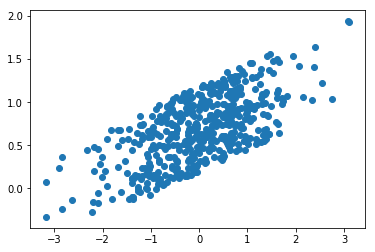

In [8]:
# 1 dimension
size=500
X,y,W = get_linear_dataset_with_bias(size,1)
plt.scatter(X[:,1],y)

Looks good. We will use higher dimension dataset for benchmarking

In [13]:
n=50
size=1000
X,y,W = get_linear_dataset_with_bias(size,n,1)

# Metric

In [10]:
def MSE(y,y_pred):
    return np.mean((y_pred -y)**2)

# Sklearn Linear Regression (benchmark)

In [14]:
from sklearn.linear_model import LinearRegression

X_train,y_train,X_val,y_val = get_X_y_cv(X,y,.2)
lr = LinearRegression()
lr.fit(X_train,y_train)
print('MSE on valid set: ')
print(MSE(y_val,lr.predict(X_val)))

MSE on valid set: 
0.3090597816208019


# Sklearn Linear Regression with L2 regularization

In [15]:
from sklearn.linear_model import Ridge

X_train,y_train,X_val,y_val = get_X_y_cv(X,y,.2)
lr = Ridge(3.5,max_iter=50,random_state=42)
lr.fit(X_train,y_train)
print('MSE on valid set: ')
print(MSE(y_val,lr.predict(X_val)))

MSE on valid set: 
0.3063183872319674


# Linear Regression with Gradient Descent and L2 regularization

In [16]:
def MSE_grad(y,y_pred):
    return (2/len(y))*(y_pred-y)
def initialize_weight(dim):
    W0 = np.array([[0]]) # bias, 1x1
    W= np.random.rand(dim,1)
    return np.concatenate((W0,W))

def plot_learning_curve(train_losses,val_losses):    
    plt.plot(range(len(train_losses)),train_losses,'o-',color='r',label='Training loss',markersize=1)
    plt.plot(range(len(train_losses)),val_losses,'o-',color='g',label='Validation loss',markersize=1)
    plt.legend(loc="best")
    plt.show()
class CustomLinearRegression():
    def __init__(self,dim,lr,n_iteration=50,l2=0):
        self.dim,self.lr,self.n_iteration,self.l2 = dim,lr,n_iteration,l2
        self.W = initialize_weight(self.dim)
        self.train_losses=[]
        self.val_losses=[]
    def fit(self,X,y,val_ratio=.2):
        X_train,y_train,X_val,y_val = get_X_y_cv(X,y,val_ratio)
        for i in range(self.n_iteration):      
            y_pred = X_train.dot(self.W)
            # MSE loss for regression
            loss = MSE(y_train,y_pred)
            
            grad = MSE_grad(y_train,y_pred) # n x 1
            
            grad_w = X_train.T.dot(grad)
            
            #ignore update of grad_w0 (bias term) since w0 does not contribute to regularization process
            grad_w[1:,:]+= 2*(self.l2/X_train.shape[0])*self.W[1:,:] # (2 *lambda / m)* weight
            
            self.W-= self.lr*grad_w 
            
            #save training loss
            self.train_losses.append(loss)
            #predict validation set
            y_val_pred = self.predict(X_val)
            val_loss = MSE(y_val,y_val_pred)
            self.val_losses.append(val_loss)
            if (i+1) % 20 == 0:
                print(f'{i+1}. Training loss: {loss}, Val loss:{val_loss}')
        
        plot_learning_curve(self.train_losses,self.val_losses)
    def get_weight(self):
        return self.W
    def predict(self,X_test):
        if X_test.shape[1] == self.dim:
            X0 = np.array([[1]*X_test.shape[0]]).T # nx1
            X_test = np.concatenate((X0,X_test),axis=1)
        return X_test.dot(self.W)

## 1 dimension dataset (sanity check)

20. Training loss: 1.0500854128117312, Val loss:1.021206381320524
40. Training loss: 0.4978421933047994, Val loss:0.4721949901869825
60. Training loss: 0.2615399420596584, Val loss:0.24208553545434136
80. Training loss: 0.15998701194519518, Val loss:0.1463451521417851
100. Training loss: 0.11616715319456411, Val loss:0.10706463930184197
120. Training loss: 0.0971884522127266, Val loss:0.09135179150263563
140. Training loss: 0.08894058427757695, Val loss:0.08535287452563865
160. Training loss: 0.08534506364479075, Val loss:0.08326728538980255
180. Training loss: 0.08377326596474308, Val loss:0.082693971796074
200. Training loss: 0.08308441919099127, Val loss:0.08265938813493431


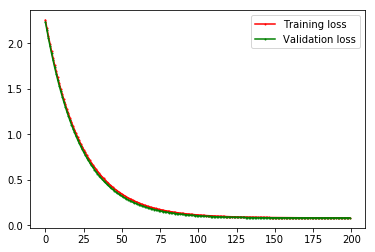

In [17]:
size=500
X1,y1,W = get_linear_dataset_with_bias(size,1)

lr = CustomLinearRegression(1,0.01,200)
lr.fit(X1,y1)

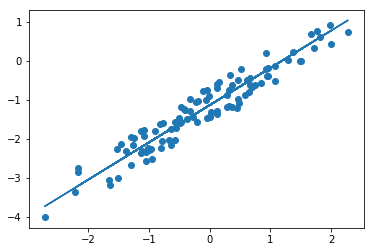

In [18]:
X_train,y_train,X_val,y_val = get_X_y_cv(X1,y1)

y_val_pred = lr.predict(X_val)
plt.scatter(X_val[:,1],y_val)
plt.plot(X_val[:,1],y_val_pred)
plt.show()

## n dimension dataset

In [19]:
print(f'X shape: {len(X)},{len(X[0])}')

X shape: 1000,51


## No regularization (l2 = 0)

20. Training loss: 27.986910892820468, Val loss:29.35093996873659
40. Training loss: 13.196876320347787, Val loss:14.543109775024426
60. Training loss: 6.566989796574637, Val loss:7.503237678106591
80. Training loss: 3.4642507682035797, Val loss:4.029483851423919
100. Training loss: 1.9539528329698062, Val loss:2.2626914314916173
120. Training loss: 1.1931908542259033, Val loss:1.343018667409267
140. Training loss: 0.7988280414292095, Val loss:0.8563698087669865
160. Training loss: 0.5895590176965263, Val loss:0.5962244243885941
180. Training loss: 0.4764068754180562, Val loss:0.45658389270229877
200. Training loss: 0.4143048996844929, Val loss:0.3817983912672281
220. Training loss: 0.37981381784804485, Val loss:0.3421471121114207
240. Training loss: 0.360474877255172, Val loss:0.32156062717212086
260. Training loss: 0.3495482917623079, Val loss:0.31128025853507935
280. Training loss: 0.34333606984764287, Val loss:0.30651247474654825
300. Training loss: 0.33978593831284415, Val loss:0.

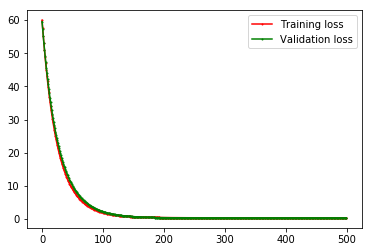

In [20]:
lr = CustomLinearRegression(n,0.01,500,l2=0)
lr.fit(X,y)

## With regularization

20. Training loss: 31.36220955914424, Val loss:30.614073606568535
40. Training loss: 14.551601816582133, Val loss:14.988520239944622
60. Training loss: 7.1461252015953685, Val loss:7.6651288509405795
80. Training loss: 3.72835321466967, Val loss:4.090938563033751
100. Training loss: 2.0826675712484426, Val loss:2.288252208679398
120. Training loss: 1.2605198566578475, Val loss:1.3557721636503401
140. Training loss: 0.8368461915511948, Val loss:0.8644685882505718
160. Training loss: 0.6128036846563597, Val loss:0.6023867659180255
180. Training loss: 0.4917354312430781, Val loss:0.4616052407718347
200. Training loss: 0.4250846463984503, Val loss:0.38585879106718624
220. Training loss: 0.38777789408635127, Val loss:0.3452802266012395
240. Training loss: 0.3665697731022808, Val loss:0.3238020982948514
260. Training loss: 0.35432932492799657, Val loss:0.31269846096004966
280. Training loss: 0.34715511521194337, Val loss:0.3072015827496937
300. Training loss: 0.3428822501549628, Val loss:0.3

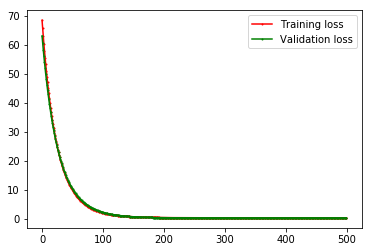

In [21]:
lr = CustomLinearRegression(n,0.01,500,l2=2.8)
lr.fit(X,y)

<b>Log loss on validation set (0.3059) is comparable to Sklearn Linear Regression!